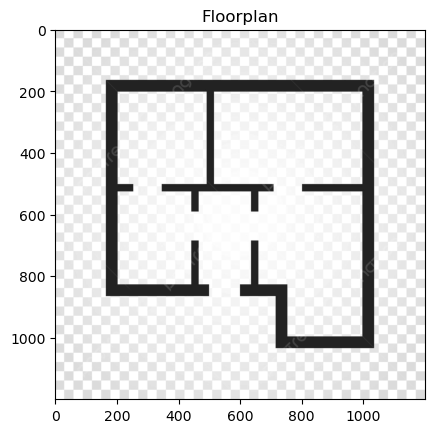

In [25]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = "/Users/amanchandel/Work/projects/MCV2/floorplans/floorplan1.png"  # Replace with your floorplan image path
image = cv2.imread(image_path)

# Convert to grayscale for processing
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the image

plt.imshow(gray_image, cmap="gray")
plt.title("Floorplan")
plt.show()

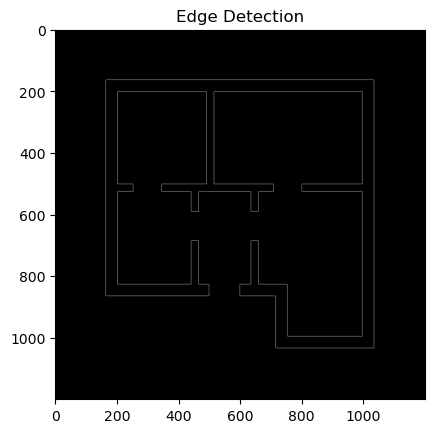

In [27]:
# Thresholding to create a binary image
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

# Edge detection
edges = cv2.Canny(binary_image, threshold1=50, threshold2=150)

# Display the processed image
plt.imshow(edges, cmap="gray")
plt.title("Edge Detection")
plt.show()


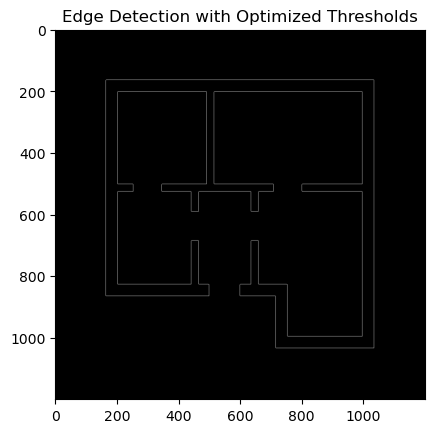

In [29]:
import numpy as np
# Dynamically calculate thresholds for Canny edge detection
median_val = np.median(binary_image)
lower_threshold = int(max(0, 0.7 * median_val))
upper_threshold = int(min(255, 1.3 * median_val))

edges = cv2.Canny(binary_image, lower_threshold, upper_threshold)

# Display the edge-detected image
plt.imshow(edges, cmap="gray")
plt.title("Edge Detection with Optimized Thresholds")
plt.show()


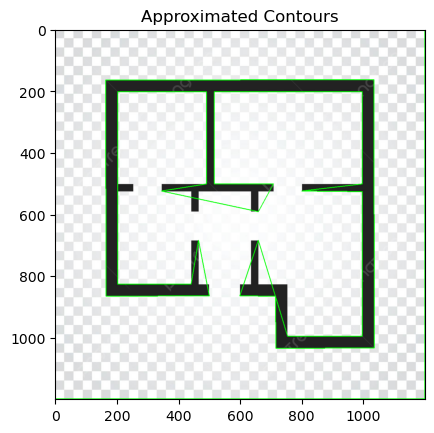

In [31]:
# Detect and approximate contours
contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
approximated_contours = [
    cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
    for contour in contours
]

# Draw the approximated contours on the original image
contour_image = image.copy()
cv2.drawContours(contour_image, approximated_contours, -1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Approximated Contours")
plt.show()

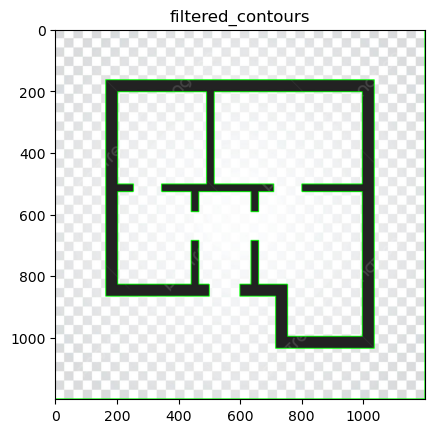

In [33]:
import numpy as np

# Detect contours
filtered_contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("filtered_contours")
plt.show()

In [35]:
# Extract coordinates from filtered contours
coordinates = []
for contour in filtered_contours:
    for point in contour:
        x, y = point[0]  # Extract x, y from the contour point
        coordinates.append((x, y))

# Normalize coordinates
max_x = max([coord[0] for coord in coordinates])
max_y = max([coord[1] for coord in coordinates])


scaled_coordinates = [(x / max_x, y / max_y) for x, y in coordinates]
excluded_coordinates = [(0.0, 0.0), (0.0, 1.0), (1.0, 1.0), (1.0, 0.0)]
filtered_scaled_coordinates = [coord for coord in scaled_coordinates if coord not in excluded_coordinates]
print("Filtered and Normalized Coordinates:")
print(filtered_scaled_coordinates)



Filtered and Normalized Coordinates:
[(0.13678065054211844, 0.13761467889908258), (0.13761467889908258, 0.13678065054211844), (0.8623853211009175, 0.13678065054211844), (0.8632193494578816, 0.13761467889908258), (0.8632193494578816, 0.8623853211009175), (0.8623853211009175, 0.8632193494578816), (0.5971643035863219, 0.8632193494578816), (0.5963302752293578, 0.8623853211009175), (0.5963302752293578, 0.7222685571309424), (0.5004170141784821, 0.7222685571309424), (0.49958298582151794, 0.7214345287739783), (0.49958298582151794, 0.6905754795663053), (0.5004170141784821, 0.6897414512093412), (0.5296080066722268, 0.6897414512093412), (0.5296080066722268, 0.5721434528773979), (0.530442035029191, 0.5713094245204337), (0.5496246872393661, 0.5713094245204337), (0.5504587155963303, 0.5721434528773979), (0.5504587155963303, 0.6897414512093412), (0.6271893244370309, 0.6897414512093412), (0.6288573811509591, 0.6914095079232694), (0.6288573811509591, 0.8306922435362802), (0.8306922435362802, 0.83069224

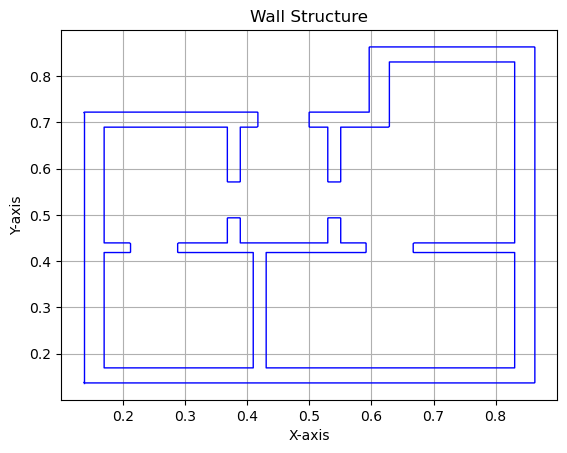

In [37]:
import matplotlib.pyplot as plt

# Example: Assuming scaled_coordinates is already defined and contains normalized wall coordinates

# Separate x and y coordinates
x_coords, y_coords = zip(*filtered_scaled_coordinates)

# Plot lines connecting the coordinates
plt.plot(x_coords, y_coords, linestyle='-', linewidth=1, color='blue')

# To close the wall (if it forms a loop), connect the last point back to the first
plt.plot([x_coords[-1], x_coords[0]], [y_coords[-1], y_coords[0]], linestyle='-', linewidth=1, color='blue')

# Add labels and grid
plt.title("Wall Structure")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid()

# Show the plot
plt.show()


In [52]:
import csv
with open("coordinates.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["X", "Y"])
    writer.writerows(filtered_scaled_coordinates)

print("Filtered coordinates saved to filtered_coordinates.csv")

Filtered coordinates saved to filtered_coordinates.csv


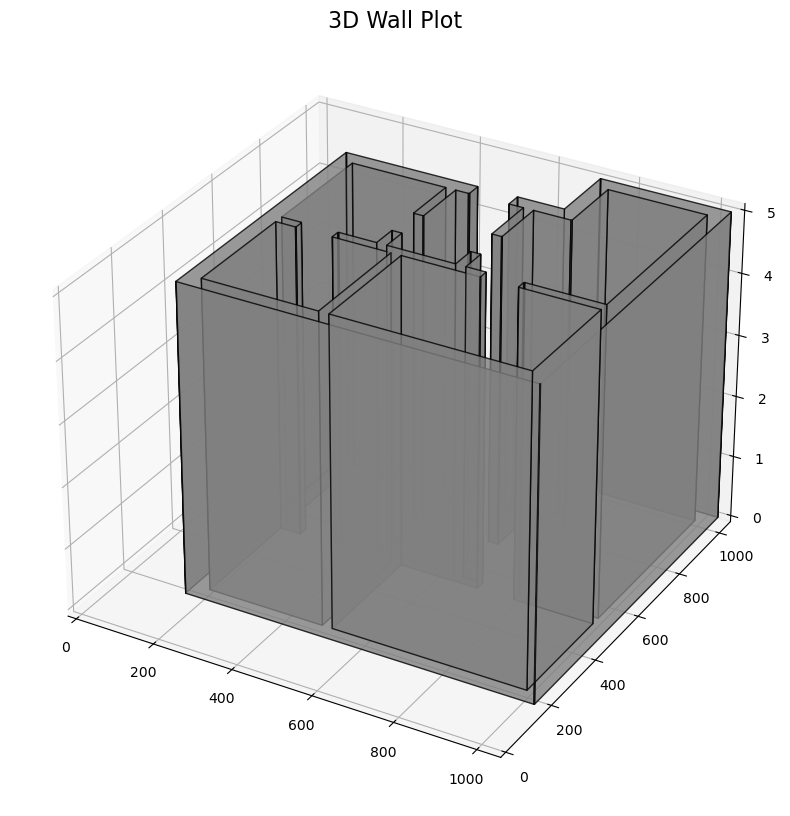

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# Example wall height (adjustable)
wall_height = 5

# Convert 2D wall coordinates to 3D by adding height
wall_planes = []
for contour in filtered_contours:
    wall = []
    for pt in contour:
        x, y = pt[0]  # Extract x, y
        wall.append([x, y, 0])  # Bottom of the wall
        wall.append([x, y, wall_height])  # Top of the wall
    wall_planes.append(wall)
    
wall_planes.pop(0)
# Plot the walls in 3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Add walls as vertical planes
for wall in wall_planes:
    # Convert the wall into polygons for 3D visualization
    vertices = [
        [wall[i], wall[i + 1], wall[(i + 3) % len(wall)], wall[(i + 2) % len(wall)]]
        for i in range(0, len(wall), 2)
    ]
    poly3d = Poly3DCollection(vertices, alpha=0.8, facecolor='gray', edgecolor='k')
    ax.add_collection3d(poly3d)


# Set limits to fit the walls
ax.set_xlim(0, np.max([coord[0] for wall in wall_planes for coord in wall]))
ax.set_ylim(0, np.max([coord[1] for wall in wall_planes for coord in wall]))
ax.set_zlim(0, wall_height)



plt.title("3D Wall Plot", fontsize=16)
plt.show()


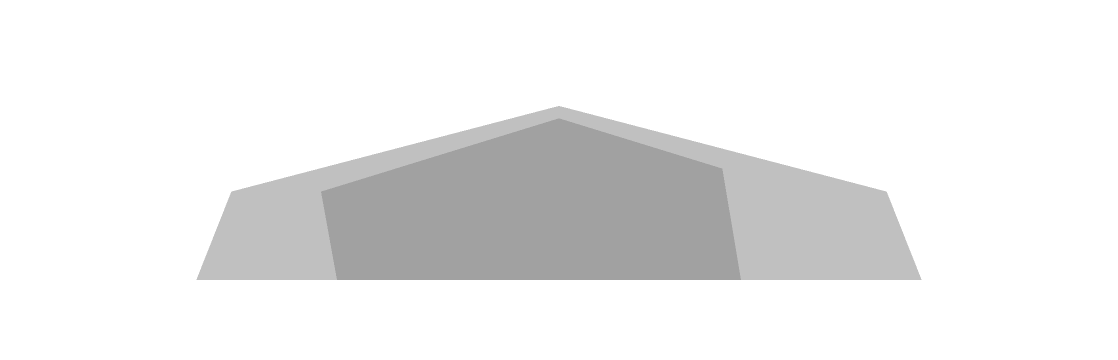

In [43]:
import plotly.graph_objects as go

# Convert 2D wall coordinates to 3D by adding height
wall_traces = []
for contour in filtered_contours:
    x, y, z = [], [], []
    for pt in contour:
        x.append(pt[0][0])
        y.append(pt[0][1])
        z.append(0)  # Bottom
    x += [pt[0][0] for pt in contour]
    y += [pt[0][1] for pt in contour]
    z += [wall_height] * len(contour)  # Top

    # Create a trace for the wall
    wall_traces.append(
        go.Mesh3d(
            x=x,
            y=y,
            z=z,
            color='grey',
            opacity=.5
        )
    )

# Create the figure
fig = go.Figure(data=wall_traces)

# Customize layout to remove axes
fig.update_layout(
    scene=dict(
        xaxis_visible=False,
        yaxis_visible=False,
        zaxis_visible=False,
        aspectmode="data"
    )
)

fig.show()
